Здесь описана решение задачи классификации:
1) страны по количеству самоубийств и HDI(что то вроде индекса качества жизни)  
2) пола(мужской\женский) группы самоубийц по полям количества самоубийств и общей численности группы

## Подгрузка всякого(датасет + вспом. функции)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

DIR_PATH = '../data/suicide/'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# /kaggle/input
for dirname, _, filenames in os.walk(DIR_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../data/suicide/HDI.csv
../data/suicide/master.csv
../data/suicide/postUSSR_90_00.csv
../data/suicide/postUSSR_suicide.csv


In [4]:
df = pd.read_csv(os.path.join(DIR_PATH, 'postUSSR_90_00.csv'))
df.head()

,Unnamed: 0,country,year,sex,age,suicides_no,population,country-year,HDI,generation
0,0,Armenia,1990,male,35-54 years,25,332700,Armenia1990,0.632,Silent
1,1,Armenia,1990,male,75+ years,2,26900,Armenia1990,0.632,G.I. Generation
2,2,Armenia,1990,male,55-74 years,11,183800,Armenia1990,0.632,G.I. Generation
3,3,Armenia,1990,male,25-34 years,16,307100,Armenia1990,0.632,Boomers
4,4,Armenia,1990,female,35-54 years,15,358000,Armenia1990,0.632,Silent


In [5]:
from sklearn.model_selection import train_test_split

# функция подготовки датасета для использования в модели
def class_get_prepared_dataset(base_df, feature_columns, target):
    base_df = base_df.copy()
    # выделение таргета и X
    y = base_df[target]
    X = base_df.loc[:, feature_columns]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=0)
    
    object_cols = X.dtypes == 'object'
    object_cols = list(object_cols[object_cols].index)
    if object_cols:
        train_X, val_X = get_OH_encodings(train_X, val_X, object_cols)
        
    return train_X, val_X, train_y, val_y

In [7]:
from sklearn.tree import DecisionTreeClassifier

# функция определения модели, с получением оценки качества модели
def class_get_model(base_df, columns, target):
    train_X, val_X, train_y, val_y = class_get_prepared_dataset(base_df, columns, target)

    model = DecisionTreeClassifier(max_depth=5)
    model.fit(train_X, train_y)
    
    model_score = model.score(val_X, val_y)
    
    return model, model_score

class_get_model(df, ['suicides_no', 'HDI'], 'country')

(DecisionTreeClassifier(max_depth=5), 0.8454545454545455)

In [10]:
# OH Encoding
from sklearn.preprocessing import OneHotEncoder

# получения one-hot encoding представления не количественных столбцов
def get_OH_encodings(train_X, val_X, object_cols):
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_X[object_cols]))
    OH_cols_valid = pd.DataFrame(OH_encoder.transform(val_X[object_cols]))

    # восстанавливаю индексы после энкодинга
    OH_cols_train.index = train_X.index
    OH_cols_valid.index = val_X.index

    OH_cols_train.columns = OH_encoder.get_feature_names_out()
    OH_cols_valid.columns = OH_encoder.get_feature_names_out()

    num_x_train = train_X.drop(object_cols, axis=1)
    num_x_valid = val_X.drop(object_cols, axis=1)

    OH_X_train = pd.concat([num_x_train, OH_cols_train], axis=1)
    OH_X_valid = pd.concat([num_x_valid, OH_cols_valid], axis=1)
    
    return OH_X_train, OH_X_valid

In [11]:
def class_get_column_comb_rating(base_df, target):
    # получение комбинаций(сочетаний без повторений) столбцов
    import itertools

    columns = np.array(base_df.columns)
    columns = columns[columns != target]

    columns_combinations = []
    for i in range(1, len(columns) + 1):
        columns_combinations += itertools.combinations(columns, i)
    
    # оценка каждого из сочетаний столбцов, по МАЕ
    df_column_option = []
    for option in columns_combinations:
        column_name = '|'.join(option)
        cols_count = len(option)
        _, model_score = class_get_model(base_df, option, target)
        df_column_option.append([column_name, cols_count, model_score])

    df_column_option = pd.DataFrame(
        df_column_option, columns=['column_name', 'cols_count', 'model_score'])
    return df_column_option

class_get_column_comb_rating(df, 'country')

,column_name,cols_count,model_score
0,Unnamed: 0,1,0.851515
1,year,1,0.033333
2,sex,1,0.072727
3,age,1,0.054545
4,suicides_no,1,0.315152
...,...,...,...
506,Unnamed: 0|year|sex|suicides_no|population|cou...,8,0.754545
507,Unnamed: 0|year|age|suicides_no|population|cou...,8,0.754545
508,Unnamed: 0|sex|age|suicides_no|population|coun...,8,0.754545
509,year|sex|age|suicides_no|population|country-ye...,8,0.927273


## Классификация страны по количеству самоубийств и HDI
Эта пара выбрана как наиболее простая и в тоже время полно описывающая зависимость значения поля страна от данных в датасете(или иначе говоря, какой стране наиболее характерны такой набор данных).

In [13]:
df_column_option = class_get_column_comb_rating(df, 'country')
options_suicides = df_column_option.column_name.str.startswith('suicides_no')
df_column_option = df_column_option[options_suicides]
df_column_option.head()

,column_name,cols_count,model_score
4,suicides_no,1,0.315152
35,suicides_no|population,2,0.500000
36,suicides_no|country-year,2,0.306061
37,suicides_no|HDI,2,0.845455
38,suicides_no|generation,2,0.290909


Определяю модель с наилучшим показателем `score`, при наименьшем количестве столбцов.

(Вариант `suicides_no|population|HDI` не выбрал, т.к. количество самоубийств и человек в группе - коррелируют меж собой, что может оказать влияние на результаты и уменьшить роль поля `HDI`, при этом)

In [14]:
df_column_option = df_column_option.sort_values(by=['model_score', 'cols_count'], 
                                                ascending=[False, True])
df_column_option.head(10)

,column_name,cols_count,model_score
120,suicides_no|population|HDI,3,0.927273
250,suicides_no|population|country-year|HDI,4,0.927273
252,suicides_no|population|HDI|generation,4,0.927273
380,suicides_no|population|country-year|HDI|genera...,5,0.927273
37,suicides_no|HDI,2,0.845455
122,suicides_no|country-year|HDI,3,0.845455
124,suicides_no|HDI|generation,3,0.845455
253,suicides_no|country-year|HDI|generation,4,0.845455
121,suicides_no|population|generation,3,0.524242
251,suicides_no|population|country-year|generation,4,0.524242


In [16]:
def class_get_predictions_df(model, df, columns, target):    
    _, val_X, _, val_y = class_get_prepared_dataset(df, columns, target)
    preds = model.predict(val_X)
    preds = pd.Series(preds, index=val_X.index, name='predictions')
    result = df.loc[val_X.index]
    result['preds'] = preds
    return result

model, _ = class_get_model(df, ['suicides_no', 'HDI'], 'country')
class_get_predictions_df(model, df, ['suicides_no', 'HDI'], 'country')

,Unnamed: 0,country,year,sex,age,suicides_no,population,country-year,HDI,generation,preds
658,659,Kyrgyzstan,1990,female,5-14 years,4,502700,Kyrgyzstan1990,0.615,Generation X,Azerbaijan
406,407,Georgia,1990,male,5-14 years,0,444500,Georgia1990,0.672,Generation X,Georgia
1202,1203,Uzbekistan,1992,male,25-34 years,258,1741600,Uzbekistan1992,0.594,Boomers,Uzbekistan
202,203,Azerbaijan,1995,male,5-14 years,0,829300,Azerbaijan1995,0.609,Millenials,Azerbaijan
1187,1188,Uzbekistan,1991,male,35-54 years,353,1510300,Uzbekistan1991,0.594,Boomers,Uzbekistan
...,...,...,...,...,...,...,...,...,...,...,...
1008,1009,Turkmenistan,1998,male,25-34 years,74,363200,Turkmenistan1998,0.666,Generation X,Turkmenistan
131,132,Azerbaijan,1990,male,35-54 years,41,587300,Azerbaijan1990,0.609,Silent,Azerbaijan
15,15,Armenia,1991,male,55-74 years,9,203100,Armenia1991,0.605,Silent,Azerbaijan
1124,1125,Ukraine,1996,female,15-24 years,165,3595700,Ukraine1996,0.668,Generation X,Ukraine


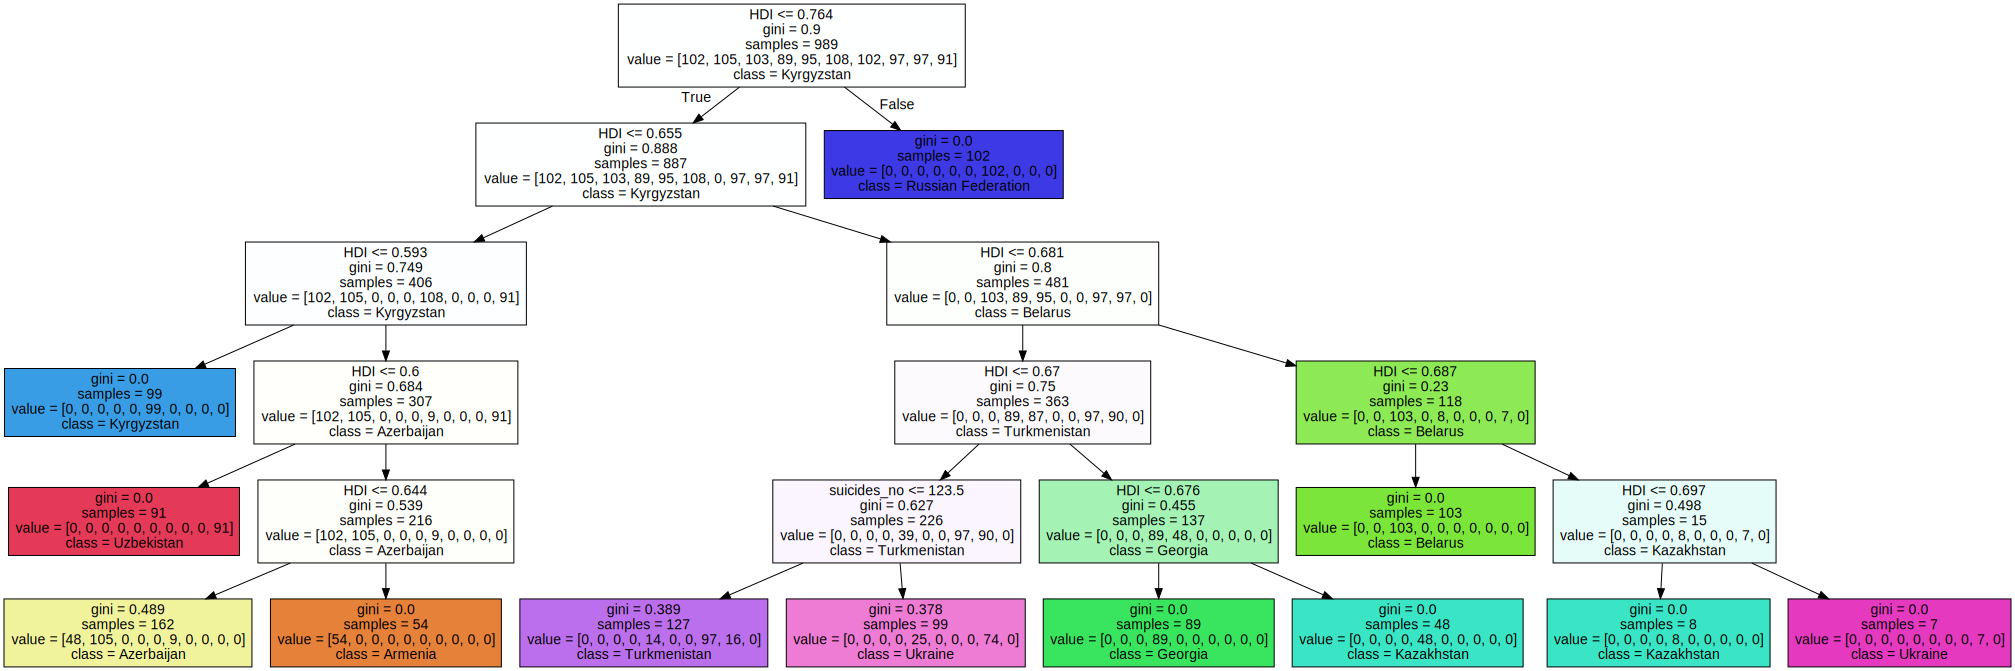

In [19]:
from sklearn.tree import export_graphviz
import graphviz

def print_graph(data, col_combination, target):
    dot_data = export_graphviz(data, out_file=None,
                               feature_names=col_combination,
                               class_names=target,
                               filled=True)
    return graphviz.Source(dot_data)

class_names = df.country.unique()
class_names.sort()

model, _ = class_get_model(df, ['suicides_no', 'HDI'], 'country')
print_graph(model, ['suicides_no', 'HDI'], class_names)

## Классификация по Sex

In [21]:
df_column_option = class_get_column_comb_rating(df, 'sex')
options_suicides = df_column_option.column_name.str.startswith('suicides_no')
df_column_option = df_column_option[options_suicides] \
    .sort_values(by=['model_score', 'cols_count'])
df_column_option.head()

,column_name,cols_count,model_score
38,suicides_no|generation,2,0.612121
123,suicides_no|country-year|generation,3,0.612121
36,suicides_no|country-year,2,0.621212
4,suicides_no,1,0.633333
124,suicides_no|HDI|generation,3,0.660606


In [22]:
col_combination = 'suicides_no|population'.split('|')
col_combination

['suicides_no', 'population']

In [23]:
model, model_score = class_get_model(df, col_combination, 'sex')
print(f'Model score - {model_score}')
result = class_get_predictions_df(model, df, col_combination, 'sex')
result

Model score - 0.7787878787878788


,Unnamed: 0,country,year,sex,age,suicides_no,population,country-year,HDI,generation,preds
658,659,Kyrgyzstan,1990,female,5-14 years,4,502700,Kyrgyzstan1990,0.615,Generation X,female
406,407,Georgia,1990,male,5-14 years,0,444500,Georgia1990,0.672,Generation X,female
1202,1203,Uzbekistan,1992,male,25-34 years,258,1741600,Uzbekistan1992,0.594,Boomers,male
202,203,Azerbaijan,1995,male,5-14 years,0,829300,Azerbaijan1995,0.609,Millenials,female
1187,1188,Uzbekistan,1991,male,35-54 years,353,1510300,Uzbekistan1991,0.594,Boomers,male
...,...,...,...,...,...,...,...,...,...,...,...
1008,1009,Turkmenistan,1998,male,25-34 years,74,363200,Turkmenistan1998,0.666,Generation X,male
131,132,Azerbaijan,1990,male,35-54 years,41,587300,Azerbaijan1990,0.609,Silent,male
15,15,Armenia,1991,male,55-74 years,9,203100,Armenia1991,0.605,Silent,male
1124,1125,Ukraine,1996,female,15-24 years,165,3595700,Ukraine1996,0.668,Generation X,female
